# Oyun Pazarına Ön Analiz (RAWG API ile)

## 🎯 Amaç

Yeni bir oyun geliştirmeden önce pazarı anlamak için; oyunların **tür**, **platform**, **developer** ve **publisher** kırılımlarını ve kalite dağılımını incelemeyi hedefledik.  

Bu kapsamda:

- **Zaman analizi:** Yıllara göre ortalama Metacritic puanı ve 84+ oyunların dağılımı, pandemi etkisi ve üst segmentteki değişim.  
- **Tür analizi:** Türlere göre ortalama kalite, oyuncu ilgisi (ratings_count & added), kalite–ilgi dengesini belirleme.  
- **Developer analizi:** En çok oyun çıkaran geliştiriciler, 84+ oyun oranları, rekabetten kaçınma stratejisi (özellikle Nintendo’nun baskınlığı).  
- **Publisher analizi:** 40% barajıyla segmentasyon (yüksek hacim & yüksek başarı, erişilebilir ama daha düşük başarı, prestijli niş partnerler). Indie geliştirici için potansiyel partner fırsatları.  
- **Store analizi:** Oyunların yayınlandığı mağazalarda toplam sayılar, 84+ oranları ve portlama iş yükü değerlendirmesi. Çıkış sırası için stratejik öneriler.  
- **Ek analizler:** Ratings_count ve added metrikleri üzerinden oyunlara olan topluluk ilgisi ve popülerlik eğilimleri.  
- **Unutulmazlar:** Meraklısı için, Metacritic 95+ oyunların listelenmesi (34 adet).  

**Genel amaç:**  
Sadece kaliteyi (Metacritic) değil, aynı zamanda **oyuncu ilgisini, publisher ve store stratejilerini** dikkate alarak yeni bir oyun için **doğru tür–platform–partner–zamanlama** kararlarını verebilmek.

## Veri Kaynağı
- **RAWG Video Games Database API**
- Bu çalışma, yalnızca **öğrenme ve portföy** amacıyla yapılmıştır.
- **Veri çekim tarihi:** Ağustos 2025
## Toplanan Veri
- **Adet:** 5.000 oyun
- **Seçim kriteri:** Metacritic puanına göre **yüksekten düşüğe** sıralanmış ilk 5.000 kayıt. En düşük puan 68'e kadar inmektedir.
- **Çekim stratejisi:**
  1) **Liste uç noktası:** `GET /api/games`  
     Parametreler:  
     - `ordering = -metacritic`  
     - `page_size = 40`  
     - `page = 1..n` (sayfalama ile 5.000 kayda ulaşılana kadar)
  2) **Detay zenginleştirme:** Her oyun için `GET /api/games/{id}`  
     - Bu adımda geliştirici/yayıncı/tür/mağaza bilgileri eklendi.

## Nihai Sütunlar
- `rawg_id`, `name`, `released`, `metacritic_x`, `ratings_count`, `added`, `platforms`, `developers`, `publishers`, `genres`, `stores`

> Notlar:
> - Bazı çok eski/bozuk kayıtların detay uç noktası arada **502** dönebildi; bu kayıtlar için detay alanları boş bırakılmıştır.
> - Analiz ve görselleştirmeler, bu 5.000 kayıt üzerinden gerçekleştirilmiştir.

# 0. RAWG API Bağlantı Testi (Smoke Test)

Bu adımda API anahtarının çalıştığını ve `/api/games` uç noktasına düzgün erişebildiğimizi doğruladım.

## Ne yaptım?
- **Endpoint:** `GET https://api.rawg.io/api/games`
- **Parametreler:**
  - `ordering = -metacritic`  → en yüksek Metacritic’ten başlayarak sırala
  - `page_size = 3`           → kotaları tüketmeden hızlı kontrol (3 kayıt)
  - `page = 1`                → ilk sayfa
- **Beklenen çıktı:**
  - `status: 200`
  - JSON üst anahtarlarında `results` görünüyor
  - İlk 3 oyunun `name`, `metacritic`, `ratings_count` değerleri çıkıyor

## Neden bu adım?
- Anahtar ve endpoint erişimi **doğru** mu, hızla görmek için
- JSON şemasını (üst anahtarlar) **kontrol** etmek için
- Büyük çekime (5.000 kayıt) geçmeden önce **hızlı doğrulama** yapmak için

In [105]:
import requests

# RAWG API anahtarını tanımlıyoruz
RAWG_KEY = "762732b1ace74b74b4afac1190285ebb"

# Çekmek istediğimiz endpoint: Oyun listesi
url = "https://api.rawg.io/api/games"

# Parametreler:
# - key: API anahtarımız
# - page_size: Kaç oyun gelsin (3 ile test amaçlı sınırlıyoruz)
# - ordering: "-metacritic" → Metacritic puanına göre azalan sıralama
params = {
    "key": RAWG_KEY,
    "page_size": 3,       # sadece 3 oyun gelsin
    "ordering": "-metacritic"
}

# API isteğini gönderiyoruz (15 sn timeout ile)
r = requests.get(url, params=params, timeout=15)
print("status:", r.status_code)  # HTTP durum kodunu yazdır (200 → başarılı)

# JSON verisini alıyoruz
data = r.json()

# Gelen cevaptaki en üst seviyedeki anahtarları yazdırıyoruz (ör. "results", "count", "next" vb.)
print("üst anahtarlar:", list(data.keys()))

# "results" listesindeki oyunları tek tek yazdır
for g in data.get("results", []):
    # Her oyun için isim, metacritic puanı ve ratings_count (kaç kişinin oyladığı) gösterilir
    print(g.get("name"), "| metacritic:", g.get("metacritic"), "| ratings_count:", g.get("ratings_count")) 

status: 200
üst anahtarlar: ['count', 'next', 'previous', 'results', 'seo_title', 'seo_description', 'seo_keywords', 'seo_h1', 'noindex', 'nofollow', 'description', 'filters', 'nofollow_collections']
The Legend of Zelda: Ocarina of Time | metacritic: 99 | ratings_count: 860
Soulcalibur (1998) | metacritic: 98 | ratings_count: 0
Soulcalibur | metacritic: 98 | ratings_count: 84


# 1. Veri Toplama ve Hazırlık

## 1.1 Liste Uç Noktası (Toplam 10 Örnek Oyun)
- İlk testte 10 oyun liste endpointinden çekildi.
- Çıkan alanlar: `rawg_id, name, released, metacritic_x, ratings_count, added, platforms`
- Bu adımda sadece **liste yanıtı** kullanıldı (özet bilgiler).

## 1.2 Detay Uç Noktası (Zenginleştirme)
- Her bir oyun için `GET /api/games/{id}` çağrıldı.
- Eklenen alanlar: `developers, publishers, genres, stores`
- Böylece her oyun için **tam profil** oluşturuldu.

## 1.3 Birleştirme
- Liste tablosu ile detay tablosu `rawg_id` üzerinden merge edildi.
- Sonuç: Her satır bir oyuna karşılık geliyor ve aşağıdaki sütunlara sahip:
  - `rawg_id`, `name`, `released`, `metacritic_x`, `ratings_count`, `added`,
  - `platforms`, `developers`, `publishers`, `genres`, `stores`

> Bu adımın sonunda küçük bir örnek set (10 oyun) oluşturuldu.  
> Sonraki adımda aynı süreci ölçeklendirip **5.000 oyuna** genişlettik.

In [13]:
import requests, pandas as pd, time

# 1) İlk 10 oyunu liste endpointinden çek
BASE = "https://api.rawg.io/api/games"
params = {"key": RAWG_KEY, "ordering": "-metacritic", "page_size": 10, "page": 1}
r = requests.get(BASE, params=params, timeout=20)
r.raise_for_status()
data = r.json()

rows = []
for g in data["results"]:
    rows.append({
        "rawg_id": g["id"],
        "name": g.get("name"),
        "released": g.get("released"),
        "metacritic_x": g.get("metacritic"),   # liste yanıtından gelen metacritic
        "ratings_count": g.get("ratings_count"),
        "added": g.get("added"),
        "platforms": ", ".join([p["platform"]["name"] for p in (g.get("platforms") or [])])
    })

df_list = pd.DataFrame(rows)

# 2) Detaylardan developers, publishers, genres, stores ekle
def fetch_game_details(rawg_id: int, key: str) -> dict:
    url = f"https://api.rawg.io/api/games/{rawg_id}"
    r = requests.get(url, params={"key": key}, timeout=30)
    r.raise_for_status()
    d = r.json()

    def join_names(lst, key="name"):
        return ", ".join([x.get(key) for x in (lst or []) if x.get(key)]) if lst else None

    stores = None
    if d.get("stores"):
        stores = ", ".join([(s.get("store") or {}).get("name") for s in d["stores"] if s.get("store")])

    return {
        "rawg_id": d["id"],
        "developers": join_names(d.get("developers")),
        "publishers": join_names(d.get("publishers")),
        "genres": join_names(d.get("genres")),
        "stores": stores
    }

detail_rows = []
for i, rid in enumerate(df_list["rawg_id"].tolist(), start=1):
    detail_rows.append(fetch_game_details(int(rid), RAWG_KEY))
    if i % 3 == 0 or i == len(df_list):
        print(f"detay alındı: {i}/{len(df_list)}")
    time.sleep(0.2)

df_details = pd.DataFrame(detail_rows)

# 3) Birleştir
df_final = df_list.merge(df_details, on="rawg_id", how="left")

# 4) Son tablo
print("Satır:", len(df_final), "| Sütun:", len(df_final.columns))
df_final.head(10)

detay alındı: 3/10
detay alındı: 6/10
detay alındı: 9/10
detay alındı: 10/10
Satır: 10 | Sütun: 11


,rawg_id,name,released,metacritic_x,ratings_count,added,platforms,developers,publishers,genres,stores
0,25097,The Legend of Zelda: Ocarina of Time,1998-11-21,99,860,1834,"Nintendo Switch, Nintendo 64",Nintendo,Nintendo,"Action, Adventure, RPG",Nintendo Store
1,407559,Soulcalibur (1998),1998-07-30,98,0,2,"Dreamcast, Xbox 360",None,"Bandai Namco Entertainment, Namco",Fighting,None
2,54751,Soulcalibur,1998-07-30,98,84,297,"Xbox One, iOS, Xbox 360, Android, Dreamcast","BANDAI NAMCO Entertainment America, NAMCO, Pro...","Bandai Namco Entertainment, Namco","Action, Fighting",Xbox 360 Store
3,324997,Baldur's Gate III,2023-08-03,97,912,4429,"macOS, PC, Xbox Series S/X, PlayStation 5",Larian Studios,Larian Studios,"Adventure, RPG, Strategy","PlayStation Store, GOG, Steam"
4,56123,Metroid Prime,2002-11-17,97,253,638,"Wii, GameCube",Retro Studios,Nintendo,"Action, Shooter, Adventure",None
5,28495,Perfect Dark,2000-05-22,97,175,1038,"Xbox 360, Nintendo 64","Rare, 4J Studios","Microsoft Studios, Rare","Action, Shooter","Xbox Store, Xbox 360 Store"
6,28026,Super Mario Odyssey,2017-10-27,97,1900,3821,Nintendo Switch,Nintendo,Nintendo,"Arcade, Platformer",Nintendo Store
7,27036,Super Mario Galaxy 2,2010-05-23,97,418,986,"Wii, Wii U",Nintendo,Nintendo,Platformer,Nintendo Store
8,27024,Super Mario Galaxy,2007-11-01,97,769,1597,Wii,Nintendo,Nintendo,Platformer,Nintendo Store
9,22511,The Legend of Zelda: Breath of the Wild,2017-03-03,97,3113,6212,"Nintendo Switch, Wii U",Nintendo,Nintendo,"Action, Adventure, RPG",Nintendo Store


# 2. Büyük Çekim: 5.000 Oyun (Sıralama = Metacritic ↓)

Bu adımda örnek çalışmayı ölçekleyip **5.000 oyunu** RAWG API’den çektim.  
Amaç, pazarı temsil edecek geniş bir örneklemle tür/platform/developer analizlerini daha sağlam yapmak.

## 2.1 Yöntem (Liste → Detay → Birleştir)
1) **Liste uç noktası**: `GET /api/games`  
   - `ordering = -metacritic`  → en yüksek Metacritic’ten başlayarak  
   - `page_size = 40`          → sayfa başına azami kayıt  
   - `page = 1..n`             → “next” olduğu sürece sayfalamaya devam  
   - Hedefe (`TARGET = 5000`) ulaşınca döngü durur.  
   - Liste verisinden alınan sütunlar:  
     `rawg_id, name, released, metacritic_x, ratings_count, added, platforms`

2) **Detay uç noktası**: `GET /api/games/{id}`  
   - Her oyun için tekil çağrı yapıldı.  
   - Eklenen sütunlar: `developers, publishers, genres, stores`  
   - Böylece her oyun “zengin” hale getirildi.

3) **Birleştirme**  
   - Liste + Detay tabloları `rawg_id` ile **left merge** edildi.  
   - Nihai tablo (11 sütun):  
     `rawg_id, name, released, metacritic_x, ratings_count, added, platforms, developers, publishers, genres, stores`

## 2.2 Oran Sınırlaması ve Hata Yönetimi
- Her isteğin arasına **küçük bekleme** eklendi (`time.sleep(0.25)`) → API’ye nazik davranmak için.
- Bazı eski/eksik kayıtlarda sunucu **502 (Bad Gateway)** dönebiliyor.  
  - Bu durumda o oyunun detay alanları **boş** bırakılarak akış devam etti.
  - (İstenirse retry/backoff eklenebilir.)

## 2.3 Çıktı
- Toplam satır sayısı: **≈ 5.000**
- Kaydedilen dosya: `data/rawg_5000_games.csv` (projede CSV olarak arşivlendi)
- Bu veri, sonraki adımlarda pazar fotoğrafı, zaman trendleri, tür/developer/platform analizleri için kullanıldı.

> Not: Bu çalışma yalnızca **öğrenme ve portföy** amaçlıdır; veri kaynağı **RAWG API**’dir.

In [17]:
import requests, pandas as pd, time, os
from datetime import datetime

RAWG_BASE = "https://api.rawg.io/api/games"
TARGET = 5000          # hedef oyun sayısı
PAGE_SIZE = 40
ORDERING = "-metacritic"
RATE_SLEEP_LIST = 0.25     # liste çağrıları arası bekleme (sn)
RATE_SLEEP_DETAIL = 0.25   # detay çağrıları arası bekleme (sn)

# ---------- 1) LISTE: temel alanlar ----------
rows = []
page = 1
print(">> Liste çekimi başlıyor...")
while len(rows) < TARGET:
    params = {
        "key": RAWG_KEY,
        "page_size": PAGE_SIZE,
        "page": page,
        "ordering": ORDERING
    }
    r = requests.get(RAWG_BASE, params=params, timeout=30)
    r.raise_for_status()
    data = r.json()

    for g in data.get("results", []):
        rows.append({
            "rawg_id": g.get("id"),
            "name": g.get("name"),
            "released": g.get("released"),
            "metacritic_x": g.get("metacritic"),
            "ratings_count": g.get("ratings_count"),
            "added": g.get("added"),
            "platforms": ", ".join([p["platform"]["name"] for p in (g.get("platforms") or [])])
        })
        if len(rows) >= TARGET:
            break

    if not data.get("next"):
        print(">> Sayfa bitti (next yok).")
        break
    page += 1
    if page % 5 == 0:
        print(f"  - İşlenen sayfa: {page}, toplanan satır: {len(rows)}")
    time.sleep(RATE_SLEEP_LIST)

df_list = pd.DataFrame(rows).drop_duplicates(subset=["rawg_id"]).reset_index(drop=True)
print(">> Liste tamamlandı. Satır:", len(df_list))

# ---------- 2) DETAY: developers, publishers, genres, stores ----------
def fetch_game_details(rawg_id: int, key: str) -> dict:
    url = f"https://api.rawg.io/api/games/{rawg_id}"
    r = requests.get(url, params={"key": key}, timeout=30)
    r.raise_for_status()
    d = r.json()

    def join_names(lst, key="name"):
        return ", ".join([x.get(key) for x in (lst or []) if isinstance(x, dict) and x.get(key)]) if lst else None

    stores = None
    if d.get("stores"):
        stores = ", ".join([(s.get("store") or {}).get("name") for s in d["stores"] if (s.get("store") or {}).get("name")])

    return {
        "rawg_id": d.get("id"),
        "developers": join_names(d.get("developers")),
        "publishers": join_names(d.get("publishers")),
        "genres": join_names(d.get("genres")),
        "stores": stores
    }

detail_rows = []
print(">> Detay çekimi başlıyor...")
for i, rid in enumerate(df_list["rawg_id"].tolist(), start=1):
    try:
        detail_rows.append(fetch_game_details(int(rid), RAWG_KEY))
    except Exception as e:
        # hata olursa boş kayıt koyup devam edelim
        detail_rows.append({"rawg_id": int(rid), "developers": None, "publishers": None, "genres": None, "stores": None})
        print(f"  ! detay hatası (id={rid}): {type(e).__name__} - {e}")
    if i % 100 == 0 or i == len(df_list):
        print(f"  - Detay ilerleme: {i}/{len(df_list)}")
    time.sleep(RATE_SLEEP_DETAIL)

df_details = pd.DataFrame(detail_rows)

# ---------- 3) MERGE ----------
df_final = df_list.merge(df_details, on="rawg_id", how="left")
print(">> Birleştirildi. Boyut:", df_final.shape)

# ---------- 4) KAYDET ----------
os.makedirs("data", exist_ok=True)
stamp = datetime.utcnow().strftime("%Y%m%d_%H%M%S")
out_csv = f"data/rawg_{len(df_final)}_games_{stamp}.csv"
df_final.to_csv(out_csv, index=False)
print(">> Kaydedildi:", out_csv)

# ---------- 5) ÖZET ----------
print("\nÖrnek satırlar:")
display(df_final.head(5))
print("\nSütunlar:", list(df_final.columns))

>> Liste çekimi başlıyor...
  - İşlenen sayfa: 5, toplanan satır: 160
  - İşlenen sayfa: 10, toplanan satır: 360
  - İşlenen sayfa: 15, toplanan satır: 560
  - İşlenen sayfa: 20, toplanan satır: 760
  - İşlenen sayfa: 25, toplanan satır: 960
  - İşlenen sayfa: 30, toplanan satır: 1160
  - İşlenen sayfa: 35, toplanan satır: 1360
  - İşlenen sayfa: 40, toplanan satır: 1560
  - İşlenen sayfa: 45, toplanan satır: 1760
  - İşlenen sayfa: 50, toplanan satır: 1960
  - İşlenen sayfa: 55, toplanan satır: 2160
  - İşlenen sayfa: 60, toplanan satır: 2360
  - İşlenen sayfa: 65, toplanan satır: 2560
  - İşlenen sayfa: 70, toplanan satır: 2760
  - İşlenen sayfa: 75, toplanan satır: 2960
  - İşlenen sayfa: 80, toplanan satır: 3160
  - İşlenen sayfa: 85, toplanan satır: 3360
  - İşlenen sayfa: 90, toplanan satır: 3560
  - İşlenen sayfa: 95, toplanan satır: 3760
  - İşlenen sayfa: 100, toplanan satır: 3960
  - İşlenen sayfa: 105, toplanan satır: 4160
  - İşlenen sayfa: 110, toplanan satır: 4360
  - İşl

C:\Users\secki\AppData\Local\Temp\ipykernel_15112\2311108919.py:93: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  stamp = datetime.utcnow().strftime("%Y%m%d_%H%M%S")


,rawg_id,name,released,metacritic_x,ratings_count,added,platforms,developers,publishers,genres,stores
0,25097,The Legend of Zelda: Ocarina of Time,1998-11-21,99,860,1834,"Nintendo Switch, Nintendo 64",Nintendo,Nintendo,"Action, Adventure, RPG",Nintendo Store
1,407559,Soulcalibur (1998),1998-07-30,98,0,2,"Dreamcast, Xbox 360",None,"Bandai Namco Entertainment, Namco",Fighting,None
2,54751,Soulcalibur,1998-07-30,98,84,297,"Xbox One, iOS, Xbox 360, Android, Dreamcast","BANDAI NAMCO Entertainment America, NAMCO, Pro...","Bandai Namco Entertainment, Namco","Action, Fighting",Xbox 360 Store
3,324997,Baldur's Gate III,2023-08-03,97,912,4429,"macOS, PC, Xbox Series S/X, PlayStation 5",Larian Studios,Larian Studios,"Adventure, RPG, Strategy","PlayStation Store, GOG, Steam"
4,56123,Metroid Prime,2002-11-17,97,253,638,"Wii, GameCube",Retro Studios,Nintendo,"Action, Shooter, Adventure",None



Sütunlar: ['rawg_id', 'name', 'released', 'metacritic_x', 'ratings_count', 'added', 'platforms', 'developers', 'publishers', 'genres', 'stores']


# 2.4 Veri Kaydetme ve Temizlik

## CSV Olarak Kaydetme
- Nihai `df_final` tablosu **CSV** formatında diske yazıldı:  
  `rawg_5000_games.csv`
- Dosya Jupyter üzerinden indirilebilir link ile erişime açıldı (`FileLink`).

## Tarih Formatı Düzenleme
- `released` sütunu bazı satırlarda string olarak gelmişti.  
- Pandas `to_datetime(..., errors="coerce")` ile **datetime** tipine dönüştürüldü.  
  - Geçersiz/boş değerler `NaT` olarak işaretlendi.
- Bu adım, zaman serisi analizlerinde (`.dt.year` vb.) kullanılabilmesi için gerekliydi.

> Bu adımın sonunda veri seti hem **arşivlenmiş**, hem de **analizlere hazır** hale getirilmiş oldu.

In [18]:
df_final.to_csv("rawg_5000_games.csv", index=False)

In [19]:
from IPython.display import FileLink
FileLink("rawg_5000_games.csv")

C:\Windows\System32\rawg_5000_games.csv

In [21]:
df_final["released"] = pd.to_datetime(df_final["released"], errors="coerce")

# 3. Zaman Trendleri — Yıllara Göre Ortalama Metacritic

**Neden?**  
Veri çekim kriterimiz Metacritic olduğundan, ilk olarak yıllar bazında ortalama puanın nasıl seyrettiğine bakıyoruz.  
Bu analiz, “yeni bir oyun bugün piyasaya çıktığında piyasanın kalite çıtası hangi seviyede?” sorusuna temel bir referans verir.

**Yöntem (özet):**
- `released` tarihini `datetime` tipine dönüştürdük (`errors="coerce"`).
- Her oyun için `year = released.dt.year` çıkarıldı.
- Yıla göre gruplama yapılarak `metacritic_x` değerlerinin ortalaması alındı.

**Grafik yorumu (beklenen içgörüler):**
- Yıllar boyunca ortalama Metacritic’in artış/azalış trendi.
- Tepe/çöküş yılları (ör. nesil geçişleri, platform patlamaları).
- Trendteki kırılmaların (ör. 2007–2012 konsol geçişleri, pandemi dönemi) olası etkileri.

> Not: `released` değeri eksik olanlar dışarıda bırakılmıştır. Bu nedenle çok eski veya tarih bilgisi eksik bazı kayıtlar grafiğe yansımayabilir.


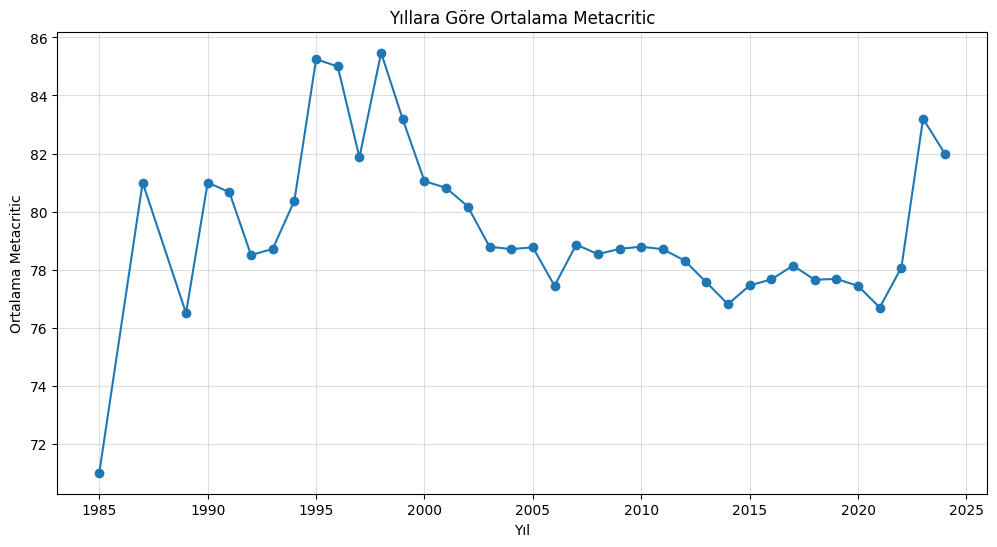

In [109]:
# "released" kolonunu datetime formatına çeviriyoruz
# errors="coerce" → hatalı tarihleri NaT (eksik değer) yapar
df_final["released"] = pd.to_datetime(df_final["released"], errors="coerce")

import matplotlib.pyplot as plt

# Yıllara göre ortalama Metacritic hesaplama
df_year = (
    df_final
    .dropna(subset=["released","metacritic_x"])   # eksik tarih veya metacritic olan satırları at
    .assign(year=lambda d: d["released"].dt.year) # tarih kolonundan sadece yılı çıkar
    .groupby("year", as_index=False)["metacritic_x"].mean()  # yıl bazında ortalama metacritic al
)

# Çizgi grafik çizimi
plt.figure(figsize=(12,6))  # grafik boyutu
plt.plot(df_year["year"], df_year["metacritic_x"], marker="o")  # yıllar x ekseni, ortalama metacritic y ekseni
plt.title("Yıllara Göre Ortalama Metacritic")  # başlık
plt.xlabel("Yıl")                             # x ekseni etiketi
plt.ylabel("Ortalama Metacritic")             # y ekseni etiketi
plt.grid(True, alpha=0.4)                     # grid çizgileri (alpha=0.4 → şeffaflık)
plt.show()                                    # grafiği göster

### Yorum — Yıllara Göre Ortalama Metacritic

Grafikte 1985–2024 arasındaki oyunların ortalama Metacritic skorları yer alıyor.  

**Öne çıkan bulgular:**
- **1990’ların ortası – 2000 başı:** Oyunların ortalama Metacritic değerleri oldukça yüksek (84–86 bandı). Bu dönem, konsol pazarının genişlediği ve “efsane” oyunların çıktığı bir dönem.
- **2005 sonrası:** Ortalama skorlar 78–80 bandına oturmuş durumda. Yani oyunların genel kalitesi **daha dengeli ve ortalama seviyeye** yakın.
- **2015–2021:** Uzun bir süre boyunca neredeyse yatay seyir var (77–79 civarı). Bu da oyun sektöründe kalite çıtasının sabitlendiğini gösteriyor.
- **2023 sonrası ani yükseliş:** Ortalama skorlar yeniden 82–83 seviyelerine çıkıyor.  
  Bunun önemli bir nedeni, **2020’de pandemi sürecinde geliştirilip ertelenen büyük oyunların 2023 itibarıyla çıkmaya başlaması** olabilir. Geliştirme süresinin uzaması kaliteyi artırmış olabilir.  
  Ancak veri setimiz **Metacritic sıralamasına göre seçildiği için** burada hafif yanlılık (bias) olabileceğini unutmamak gerek.

**Sonuç:**  
Yeni bir oyun geliştirmek isteyen biri için bu grafik şu mesajı veriyor:  
- Sektörde genel kalite 2005’ten beri **78–80 bandında sabitlenmiş**.  
- Son dönemde ortalama bir iyileşme olsa da, “yüksek Metacritic” almak için hala **84+ barajı** oldukça zorlayıcı.  
- Yeni oyunun, rekabetçi olabilmesi için en azından **84 üzeri** hedeflemesi mantıklı.

## 3.1 Yıllara Göre “Kaliteli Oyun” Sayısı (Metacritic ≥ 84)

**Neden?**  
Top-5000 verisi Metacritic’e göre seçildiği için, “yıllara göre toplam oyun sayısı” tüm pazarı temsil etmeyebilir. Bu yüzden, barajı **84** olarak belirleyip her yıl **kaç oyunun 84+** aldığını sayıyoruz. Böylece dönemler arası **yüksek kalite yoğunluğunu** daha adil karşılaştırırız.

**Yöntem (özet):**
- `released → year` çıkarıldı (eksik tarihli kayıtlar dışarıda).
- `metacritic_x ≥ 84` filtresi uygulandı.
- Yıla göre grup + adet.
- Grafikte her barın üstüne adet yazıldı.

> Not: Veri kümesi “en iyi 5000”den oluştuğu için bu metrik **üst kalite kesitindeki yoğunluğu** gösterir; tüm pazar hacmini değil.

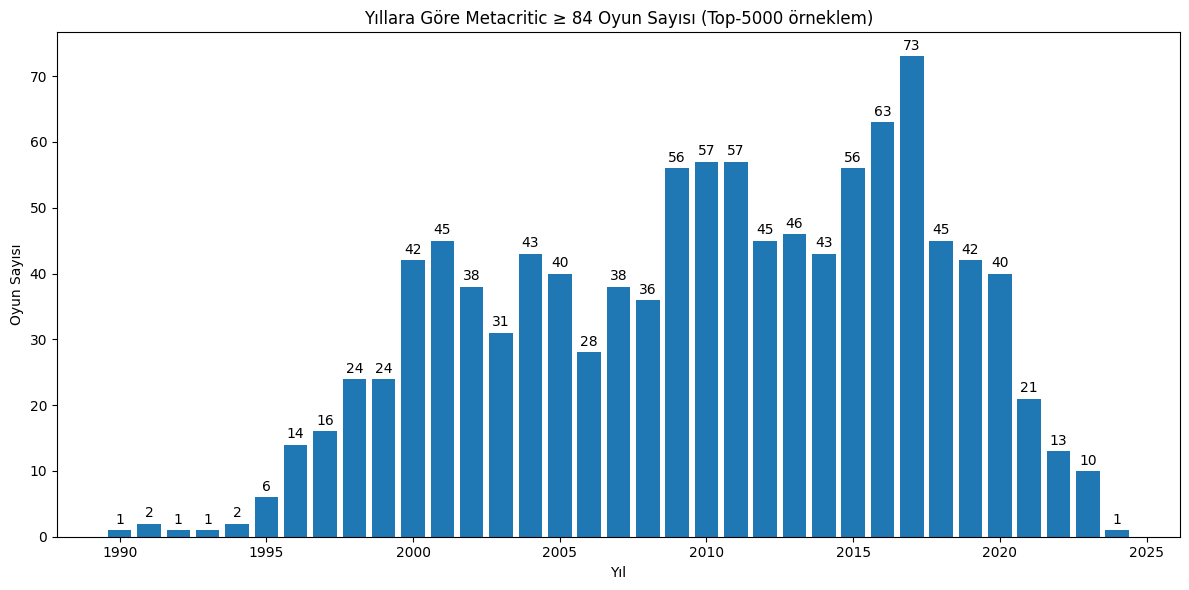

In [110]:
import matplotlib.pyplot as plt

THRESH = 84  #  Baraj değerimiz (Metacritic 84 ve üzeri oyunları alacağız)

# Veri hazırlığı
df_ge = (
    df_final
    .dropna(subset=["released","metacritic_x"])     # geçersiz tarih veya metacritic verilerini at
    .assign(year=lambda d: d["released"].dt.year)   # yıl bilgisi ekle
    .query("metacritic_x >= @THRESH")               # sadece 84+ oyunları filtrele
    .groupby("year", as_index=False)                # yıl bazında grupla
    .size()                                         # oyun sayısını hesapla
    .rename(columns={"size": f"count_ge_{THRESH}"}) # kolon adını anlamlı yap (count_ge_84)
)

# Çubuk grafik çizimi
plt.figure(figsize=(12,6))
bars = plt.bar(df_ge["year"], df_ge[f"count_ge_{THRESH}"])   # yıl → x, oyun sayısı → y
plt.title(f"Yıllara Göre Metacritic ≥ {THRESH} Oyun Sayısı (Top-5000 örneklem)")
plt.xlabel("Yıl")
plt.ylabel("Oyun Sayısı")

# Çubukların üstüne değer etiketleri ekle
for b, v in zip(bars, df_ge[f"count_ge_{THRESH}"]):
    plt.text(b.get_x()+b.get_width()/2, b.get_height()+0.5, str(int(v)),
             ha="center", va="bottom")

plt.tight_layout()   # kenarlarda taşma olmasın
plt.show()           # grafiği göster


### Yorum — Yıllara Göre Metacritic ≥ 84 Oyun Sayısı

Grafik, **her yıl Metacritic puanı 84 ve üzeri olan oyunların sayısını** göstermektedir (top-5000 örneklem üzerinden).

**Öne çıkan bulgular:**
- **2000–2010 dönemi:** Her yıl ortalama 40–50 arası yüksek puanlı oyun çıkmış; bu dönem kaliteli oyun üretiminin en istikrarlı olduğu yıllar.
- **2016–2017 zirvesi:** 2016’da 63, 2017’de 73 oyun 84+ almış. Bu, veri setindeki en yoğun yüksek kalite dönemidir.
- **2018 sonrası düşüş:** 2018’den itibaren sayı belirgin şekilde azalmış; 2021–2023’te sert düşüş var (2023’te sadece 10 oyun).
- **Olası neden:** 2020’de başlayan pandemi sürecinde birçok proje ertelendi, bu da 2021–2023 çıkışlarını azalttı.  
  Önümüzdeki birkaç yılda 2020–2023’de geliştirilen projelerin çıkmasıyla yeniden artış görülebilir.

**Sonuç:**  
Sektör, **2010’ların ortasında kalite açısından zirveye ulaşmış**; son yıllarda yüksek puanlı oyun sayısı azalmış durumda.  
Yeni geliştirilecek bir oyun için bu, pazarda “boşluk” da yaratabilir; kaliteli bir çıkış rekabetin az olduğu döneme denk gelebilir.

### Yorum — Pandemi Etkisi

Pandeminin etkisinin, oyunların **ortalama Metacritic puanlarını arttırdığını** fark etmiştik.  
Fakat aynı dönemde 84 olarak belirlediğimiz baraj üzerinden yaptığımız analizde, **üst düzey segmentteki oyun sayısının düştüğünü** görüyoruz.  

Bu sonuç bize şunu gösteriyor:  
- Genel olarak sektörde bir **kalite artışı** mevcut,  
- Ancak **üst segmentte yoğunlaşma** azalmış durumda.  
- Yani standart sapma daralmış, oyunlar daha çok **orta–üst kalite bandında** toplanmış.  

Dolayısıyla **84+ bir puan alan oyun, günümüz piyasasında daha çok dikkat çekecektir.**  
Bu da, önceki analizimizde belirlediğimiz 84 barajını mantıklı bir seçim olarak güçlendiriyor.

### Not — 2024 ve Sonrası

Grafikte 2024 yılı yalnızca **1 oyun** ile görünüyor, 2025 için ise hiç veri yok.  
Bunun nedeni veri setinin **2025 Ağustos ayında çekilmiş** olmasıdır.  
- 2024 yılı henüz tamamlanmadığı için çoğu oyunun çıkışı ve Metacritic skoru henüz işlenmemiştir.  
- 2025 için listelenen oyunlar olsa bile henüz skorlanmadığından bu analizde yer almaz.  

Dolayısıyla 2024 ve sonrası verileri **erken yıl etkisi** nedeniyle güvenilir değildir.  
Analizlerimizi yorumlarken 2023 ve öncesine odaklanmak daha doğru olacaktır.

### Tür Analizine Geçiş

Önceki adımlarımızda hedeflediğimiz **Metacritic barajını (84+)** belirlemiş olduk.  
Şimdi ise seçim için oyun türlerine odaklanıyoruz.  
Amaç, hangi türlerin genel olarak daha yüksek ortalama puanlara ulaştığını ve hangi türlerde 84+ segmentine girme olasılığının daha yüksek olduğunu görmek.

## 3.2 Tür Analizi — Ortalama Kalite ve Üst Düzey Potansiyel

Oyun geliştirmede en stratejik kararlardan biri, hangi **tür** üzerine odaklanılacağıdır.  
Bu yüzden veri setimizdeki türleri (genre) analiz ederek:  

- Türlerin **ortalama Metacritic puanlarını** (genel kalite düzeyi),  
- Türlerde **84+ segmentine girme oranlarını** (üst düzey oyun çıkarma potansiyeli),  

karşılaştırıyoruz.  

Amaç: **hangi türlerin yüksek ortalama kalite sunduğunu ve hangi türlerde üst düzey başarı şansının daha yüksek olduğunu ortaya koymak.**

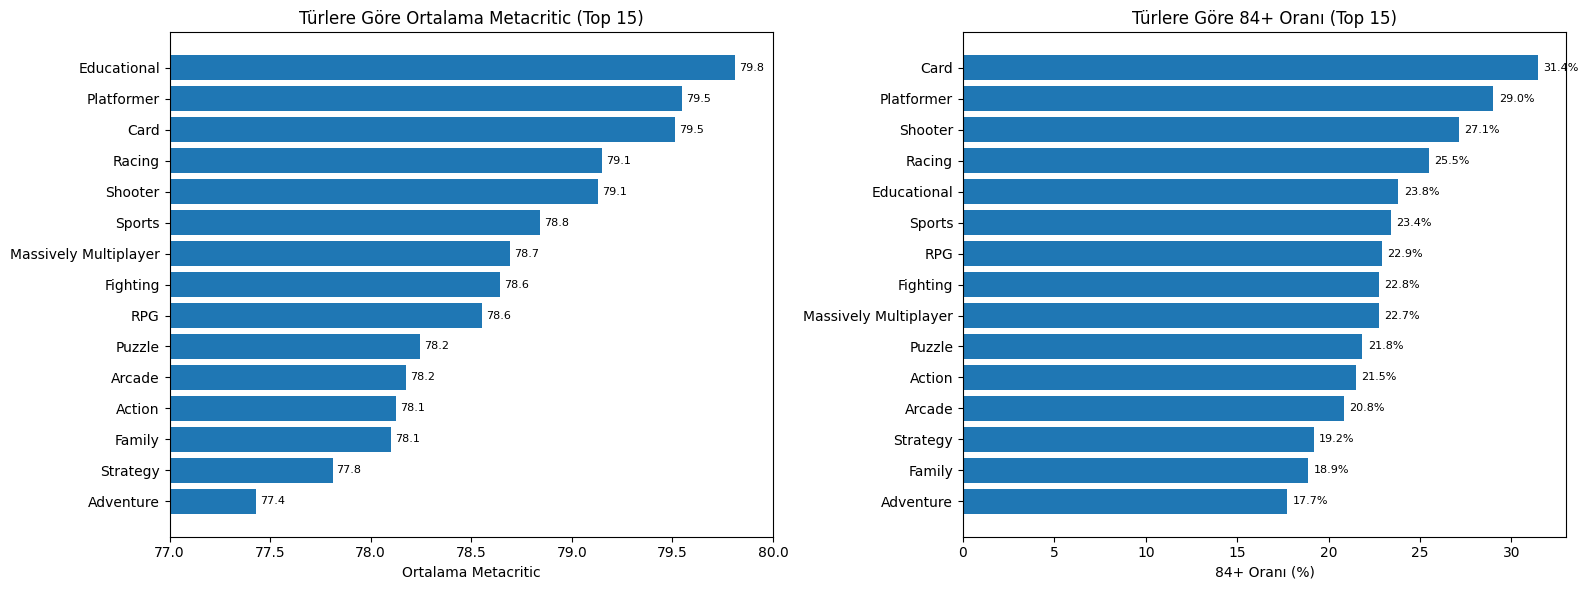

In [120]:
# 1 satır 2 kolon (yan yana grafikler) olacak şekilde figür hazırlıyoruz
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# --- Ortalama Metacritic ---
# Türlere göre ortalama Metacritic puanını en yüksekten sıralayıp ilk 15'i alıyoruz
top_mean = agg.sort_values("mean_mc", ascending=False).head(15)

# Yatay bar grafiği (barh) çizdiriyoruz, ters çevirerek üstten alta doğru sıralama yapıyoruz
bars = axes[0].barh(top_mean["genre"][::-1], top_mean["mean_mc"][::-1])

# Grafik başlığı, eksen adı ve sınırları
axes[0].set_title("Türlere Göre Ortalama Metacritic (Top 15)")
axes[0].set_xlabel("Ortalama Metacritic")
axes[0].set_xlim(77, 80)  # daha net görünüm için 77–80 aralığı zoom

# Barların üzerine sayısal değer (ortalama Metacritic) yazdırıyoruz
for b in bars:
    axes[0].text(b.get_width()+0.02, b.get_y()+b.get_height()/2,
                 f"{b.get_width():.1f}", va="center", fontsize=8)

# --- 84+ Oranı ---
# Türlere göre 84 ve üzeri puan alan oyunların oranını hesaplayıp en yüksek ilk 15'i alıyoruz
top_rate = agg.sort_values("rate_ge84", ascending=False).head(15)

# Yatay bar grafiği (barh) çizdiriyoruz
bars = axes[1].barh(top_rate["genre"][::-1], top_rate["rate_ge84"][::-1])

# Grafik başlığı ve eksen etiketi
axes[1].set_title("Türlere Göre 84+ Oranı (Top 15)")
axes[1].set_xlabel("84+ Oranı (%)")

# Barların üzerine oran değerini yüzde formatında yazdırıyoruz
for b in bars:
    axes[1].text(b.get_width()+0.3, b.get_y()+b.get_height()/2,
                 f"{b.get_width():.1f}%", va="center", fontsize=8)

# Grafiklerin taşmaması ve hizalı görünmesi için
plt.tight_layout()
plt.show()

### Yorum — Türlere Göre Metacritic Analizi

İlk grafikte (solda) türlerin **ortalama Metacritic puanları** karşılaştırılmıştır.  
Burada özellikle *Educational, Platformer, Card* türlerinin ortalamada 79+ puana ulaşarak diğer türlere kıyasla öne çıktığını görüyoruz.  
Ancak farklar dar bir aralıkta (77–80) toplandığı için genel kalite türler arasında oldukça dengeli.  

İkinci grafikte (sağda) ise türlerin **84+ segmentine girme oranı** gösterilmektedir.  
Bu metrik, bir türün “üst düzey” oyun çıkarma potansiyelini daha iyi yansıtır.  
- *Card (%31), Platformer (%29), Shooter (%27)* türleri, oyunların yaklaşık üçte birini 84+ seviyesine çıkarabilmiş.  
- Buna karşılık *Adventure (%17), Family (%18.9)* gibi türlerde üst düzeye çıkabilme oranı daha düşüktür.  

**Sonuç:**  
- Ortalama puan açısından türler birbirine yakın olsa da, **84+ oranı** yüksek olan türler (Card, Platformer, Shooter) yeni bir oyun geliştirmek için daha stratejik fırsatlar sunabilir.  
- Bu analiz, sadece “ortalama kaliteye” değil, aynı zamanda “üst düzey başarıya ulaşma olasılığına” da bakmamız gerektiğini ortaya koyuyor.


## 3.3 Tür Analizi — Etkileşim / Popülerlik (ratings_count & added)

Metacritic kaliteyi gösterirken, **oyuncu ilgisini** iki RAWG metriğiyle ölçüyoruz:
- **`ratings_count`**: Kaç kişi oy vermiş → *etkileşim yoğunluğu*  
- **`added`**: Kaç kişi koleksiyonuna/istek listesine eklemiş → *popülerlik/ilgi*

**Yöntem:**
- Oyunları tür bazında “explode” edip her tür için **medyan** `ratings_count` ve **medyan** `added` hesaplıyoruz (aşırı uçlardan etkilenmemek için medyan).
- İlk 15 türü iki metrik için ayrı ayrı listeliyoruz.

> Not: Türlerin örnek sayıları eşit değildir; “çok az oyunu” olan türler bazen şişebilir. Bu yüzden medyan kullandık.


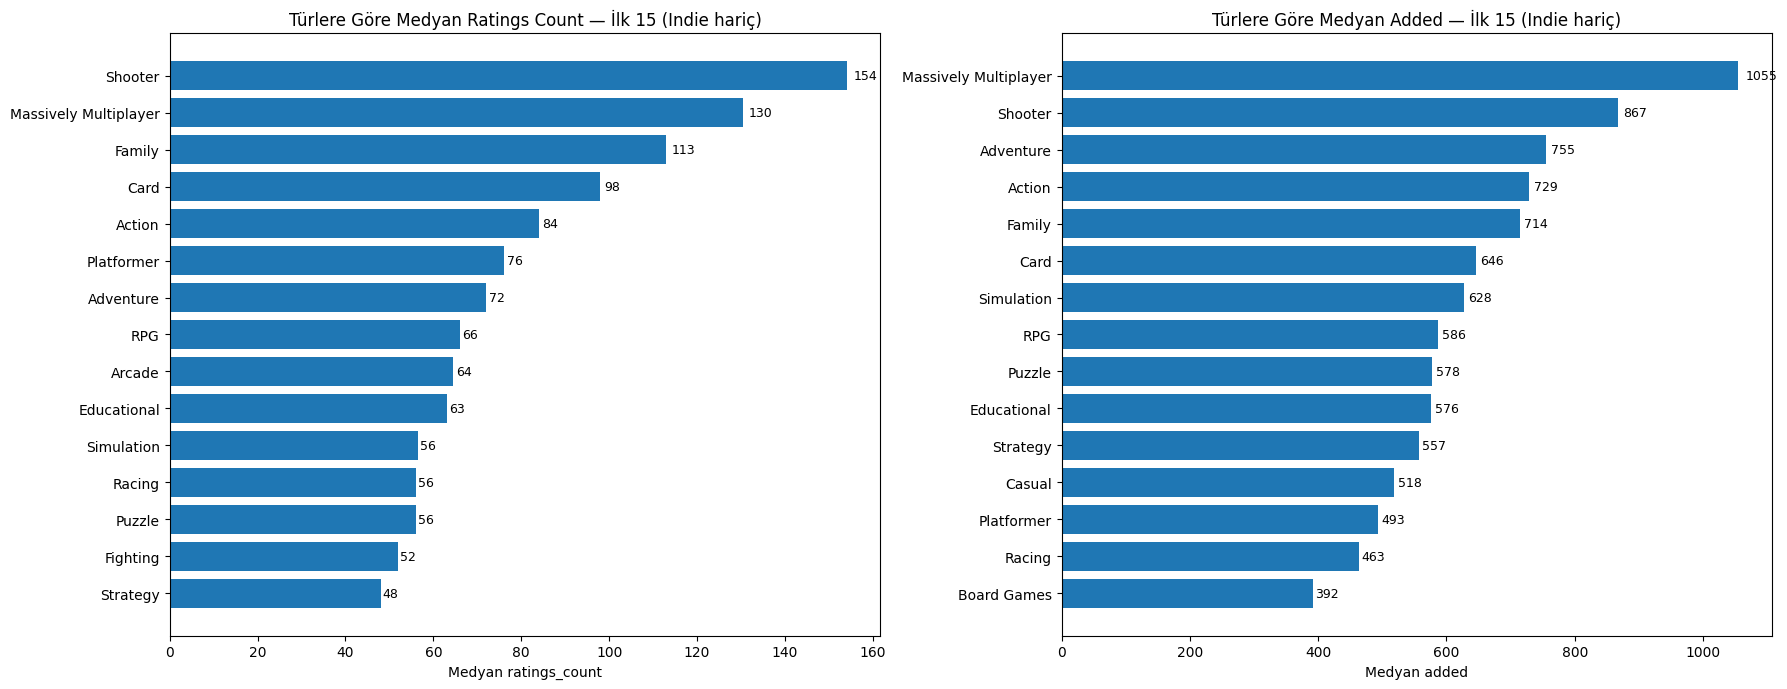

In [121]:
import pandas as pd
import matplotlib.pyplot as plt

# Hariç tutulacak türler
EXCLUDE_GENRES = {"Indie"}   # Oyun tarzlarına göre baktığımız için, indie olan bir oyun mesala metroidvania da olabildiği için indie yi tür olarak almıyoruz.

# genres + ilgi metrikleri için uzun form (Indie hariç)
rows = []
src = df_final.dropna(subset=["genres"])
for _, row in src.iterrows():
    g_list = [g.strip() for g in row["genres"].split(",") if g.strip()]
    rc = row.get("ratings_count")
    ad = row.get("added")
    for g in g_list:
        if g in EXCLUDE_GENRES:
            continue
        rows.append({
            "genre": g,
            "ratings_count": float(rc) if pd.notna(rc) else None,
            "added": float(ad) if pd.notna(ad) else None
        })

gpop = pd.DataFrame(rows)

# Tür bazında medyan ilgi metrikleri (ve örnek sayısı)
agg_pop = (
    gpop.groupby("genre", as_index=False)
        .agg(n=("ratings_count","size"),
             median_ratings=("ratings_count","median"),
             median_added=("added","median"))
        .fillna(0)
)

top_ratings = agg_pop.sort_values("median_ratings", ascending=False).head(15)
top_added   = agg_pop.sort_values("median_added",   ascending=False).head(15)

fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Sol: ratings_count (medyan)
bars1 = axes[0].barh(top_ratings["genre"][::-1], top_ratings["median_ratings"][::-1])
axes[0].set_title("Türlere Göre Medyan Ratings Count — İlk 15 (Indie hariç)")
axes[0].set_xlabel("Medyan ratings_count")
for b in bars1:
    axes[0].text(b.get_width()*1.01, b.get_y()+b.get_height()/2,
                 f"{b.get_width():.0f}", va="center", fontsize=9)

# Sağ: added (medyan)
bars2 = axes[1].barh(top_added["genre"][::-1], top_added["median_added"][::-1])
axes[1].set_title("Türlere Göre Medyan Added — İlk 15 (Indie hariç)")
axes[1].set_xlabel("Medyan added")
for b in bars2:
    axes[1].text(b.get_width()*1.01, b.get_y()+b.get_height()/2,
                 f"{b.get_width():.0f}", va="center", fontsize=9)

plt.tight_layout()
plt.show()

### Yorum — Türlerin Başarı ve İlgi Dengesi

Analizlerimizi karşılaştırdığımızda, bazı türlerin **yüksek kalite (Metacritic puanı)** getirdiğini, bazılarının ise daha çok **oyuncu ilgisi** (ratings count ve added sayısı) çektiğini görüyoruz.  

- **Platformer & Educational:**  
  Metacritic’te yüksek başarı elde etseler de (ortalama puanlarda üst sıralar), oyuncu ilgisi tarafında geride kalıyorlar.  
  → Yani **eleştirmenlerin sevdiği ama kitleye ulaşmakta zorlanan türler**.

- **Shooter & Card:**  
  Hem Metacritic puanlarında hem de oyuncu ilgisinde üst sıralarda.  
  → Bu türler, **hem başarı hem popülerlik** açısından güçlü adaylar.

- **Massively Multiplayer:**  
  Metacritic başarısı orta seviyede, ancak **en yüksek oyuncu ilgisini (added/ratings)** bu tür görüyor.  
  → Yani oyuncular tarafından çok talep görüyor ama kalite çıtasını yakalamak zor.  
  → Potansiyeli büyük, ancak rekabeti de yoğun.

- **Family & Action:**  
  Oyuncu ilgisi yüksek, Metacritic başarısı ise ortalama düzeyde.  
  → Bu türler **kitlelere ulaşmada güçlü ama eleştirmenlerden yüksek not almak daha zor** olabilir.

**Çıkarım:**  
- Eğer **yüksek puan hedefi** (84+ barajı) önceliğimizse: *Card, Shooter, Platformer*.  
- Eğer **oyuncu ilgisi ve yaygınlık** önceliğimizse: *Shooter, Massively Multiplayer, Action*.  
- Dengeli bir strateji için: **Shooter** türü öne çıkıyor çünkü her iki metriği de yüksek.

## 3.4 Developer Analizi — Rekabet ve Üst Düzey Başarı

Bir oyunun kalitesi kadar, geliştiricisinin geçmiş performansı da stratejik seçimlerde kritik öneme sahiptir.  
Bu nedenle, veri setimizdeki geliştiricileri (developer) inceleyerek:  

- Top-5000 örneklem içinde **kaç oyun çıkardıklarını** (rekabet yoğunluğu),  
- Bu oyunlardan **kaç tanesinin Metacritic ≥ 84** aldığını (üst düzey başarı),  

göreceğiz.  

Amaç: **rekabeti keşfetmek** ve “hangi stüdyolar hem çok oyun çıkarıyor hem de kalite çıtasını aşabiliyor?” sorusuna yanıt bulmak.

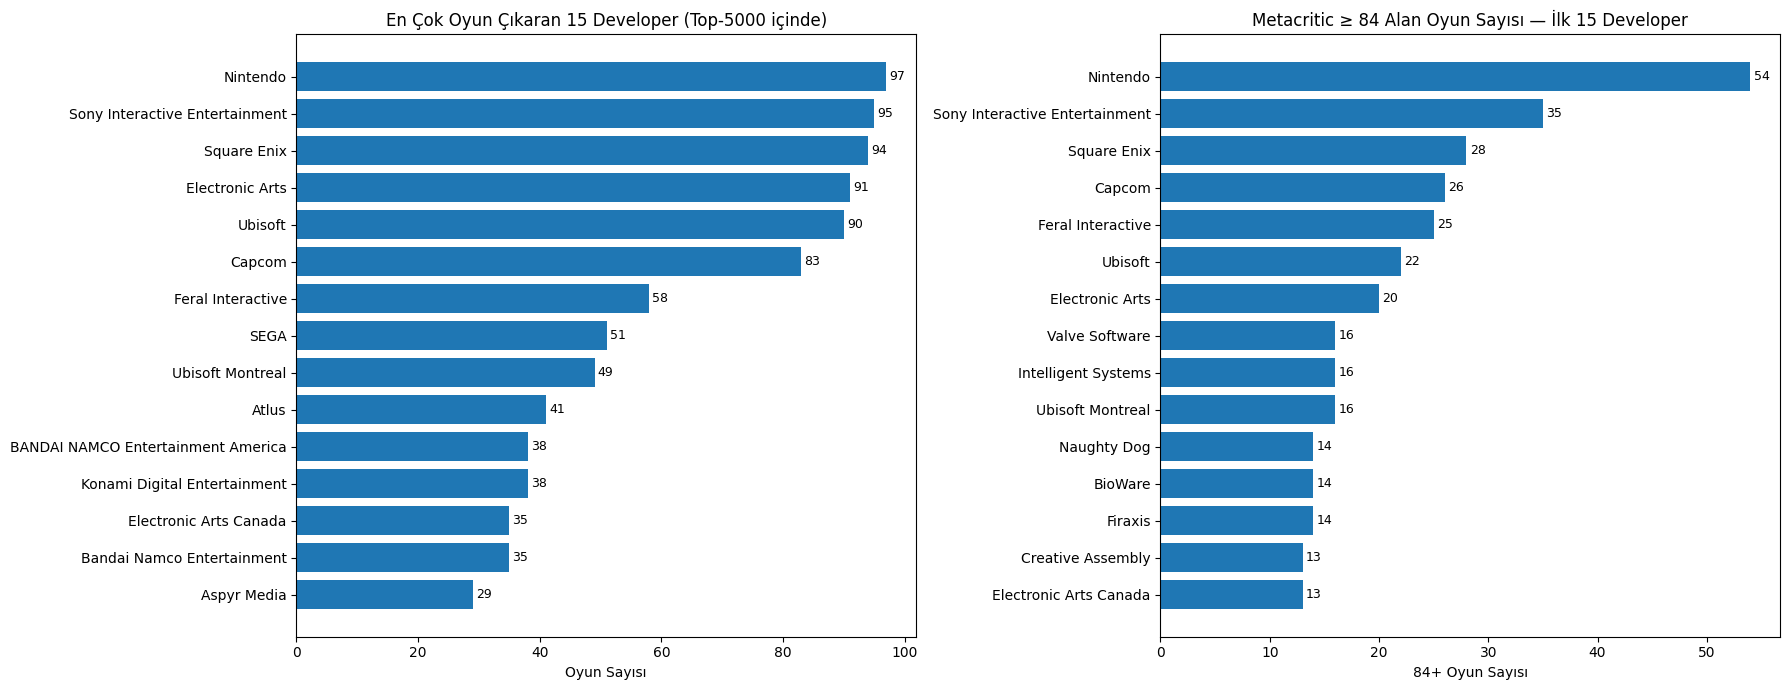

In [122]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

THRESH = 84

# 1) Developer'ları explode ederek satırlaştır
rows = []
for _, row in df_final.dropna(subset=["developers", "metacritic_x"]).iterrows():
    for d in row["developers"].split(","):
        dev = d.strip()
        if dev:
            rows.append({"developer": dev, "metacritic": float(row["metacritic_x"])})

devdf = pd.DataFrame(rows)

# 2) Metrikler: toplam oyun sayısı, 84+ sayısı, 84+ oranı
agg = (
    devdf
    .assign(ge84=lambda d: (d["metacritic"] >= THRESH).astype(int))
    .groupby("developer", as_index=False)
    .agg(n_total=("metacritic","size"),
         n_ge84=("ge84","sum"))
)
agg["rate_ge84"] = (agg["n_ge84"] / agg["n_total"] * 100).round(1)

# 3) Görselleştirme: Top 15 (rekabet & elit başarı)
top_by_total = agg.sort_values("n_total", ascending=False).head(15)
top_by_ge84  = agg.sort_values("n_ge84",  ascending=False).head(15)

fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Sol: en çok oyun çıkaran 15 developer (rekabet yoğunluğu)
bars1 = axes[0].barh(top_by_total["developer"][::-1], top_by_total["n_total"][::-1])
axes[0].set_title("En Çok Oyun Çıkaran 15 Developer (Top-5000 içinde)")
axes[0].set_xlabel("Oyun Sayısı")
for b in bars1:
    axes[0].text(b.get_width()+0.5, b.get_y()+b.get_height()/2, int(b.get_width()), va="center", fontsize=9)

# Sağ: 84+ sayısına göre en güçlü 15 developer (elit başarı)
bars2 = axes[1].barh(top_by_ge84["developer"][::-1], top_by_ge84["n_ge84"][::-1])
axes[1].set_title(f"Metacritic ≥ {THRESH} Alan Oyun Sayısı — İlk 15 Developer")
axes[1].set_xlabel("84+ Oyun Sayısı")
for b in bars2:
    axes[1].text(b.get_width()+0.3, b.get_y()+b.get_height()/2, int(b.get_width()), va="center", fontsize=9)

plt.tight_layout()
plt.show()

### Yorum — Developer Rekabeti ve Zamanlama

Soldaki grafik, Top-5000 örneklem içinde **en çok oyun çıkaran** stüdyoları (genel üretim gücü) gösteriyor.  
Sağdaki grafik ise **Metacritic ≥ 84** alan oyun **sayısına göre** stüdyoları (üst düzey başarı) sıralıyor.

**Okuma:**
- **Nintendo, Sony Interactive Entertainment, Square Enix** her iki listede de üst sıralarda. Bu stüdyolar hem **sık** üretim yapıyor hem de **yüksek puanlı** oyun çıkarma kapasitesine sahip.
- Bu nedenle **bu stüdyoların büyük lansman dönemleriyle aynı zaman dilimine çıkmak** oyunumuzun görünürlüğünü **olumsuz etkileyebilir**.  
  > Strateji: Büyük Nintendo/Sony lansmanlarının olmadığı, **nispeten sakin bir çıkış penceresi** hedeflemek mantıklı.

**Not:** Bu analiz Top-5000 (Metacritic’e göre sıralı) örneklemi temel alır; pazarın tamamını değil, **üst kalite kesitini** temsil eder. Yine de “gürültüsüz zamanlama” kararı için güçlü bir sinyal üretir.

**Çıkarım:** Üst segmentte yoğun rekabetin olduğu günlerde değil, **daha sakin dönemlerde çıkış** planlamak, 84+ hedefi olan bir oyun için görünürlüğü ve basın/oyuncu ilgisini artırabilir.

**Future Analysis:**

Nintendo, Sony Interactive Entertainment, Square Enix her iki listede de üst sıralarda. Bu stüdyolar hem sık üretim yapıyor hem de yüksek puanlı oyun çıkarma kapasitesine sahip.

Nintendo’nun özel başarısı: Sol grafikte Nintendo, toplam oyun üretimi açısından rakipleriyle (Sony, Square Enix, EA, Ubisoft, Capcom) benzer seviyede olmasına rağmen, sağ grafikte 84+ oyun çıkarma sayısında rakiplerini neredeyse 2’ye katlıyor.
Ayrıca Nintendo’nun oyun tasarımı ve geliştirme yaklaşımı (özellikle kaliteyi öne çıkaran stratejisi) incelemeye değer bir model sunuyor.

>🔮 **Future Analysis Notu**: Nintendo’nun 84+ bariyerini bu denli rahat geçmesini sağlayan faktörler ileride ayrıca incelenebilir. Bu inceleme sonucunda elde edilecek bulgular, yeni bir oyun geliştirirken doğrudan uygulanabilecek değerli içgörüler sağlayabilir.

## 3.5 — İlk 3 Developer’ın Ay Bazında 84+ Çıkış Yoğunluğu

Grafik, **Nintendo, Sony Interactive Entertainment ve Square Enix** için yıllardan bağımsız şekilde **hangi aylarda 84+ oyun çıkışlarının yoğunlaştığını** göstermektedir.  

**Öne çıkan bulgular:**
- **Nintendo:** Kasım ayında zirveye çıkıyor. Yıl sonu tatil sezonu için yapılan güçlü lansmanlar göze çarpıyor. Ayrıca Temmuz ayında da yüksek bir yoğunluk mevcut.  
- **Sony Interactive Entertainment:** En dengeli dağılıma sahip, özellikle **Mart–Nisan** ve **Eylül–Kasım** dönemlerinde çıkış yoğunluğu artıyor.  
- **Square Enix:** Mart ve Temmuz aylarında öne çıkıyor. Yaz ortasında önemli lansmanlar yaptığı görülüyor.  

**Stratejik çıkarım:**  
- Kasım ve Aralık ayları büyük firmaların yoğun lansman dönemleri olduğundan **rekabetin en yüksek olduğu zamanlar**.  
- Eğer küçük/orta ölçekli bir oyun geliştirilirse, **bu dönemlerden kaçınmak** ve daha sakin dönemleri (ör. Mayıs, Haziran, Ağustos) hedeflemek daha avantajlı olabilir.  

> 🔮 **Future Analysis Notu:** Bu analiz, sadece “ilk 3 developer” ile sınırlı. Gelecekte diğer büyük stüdyolar (Ubisoft, Capcom, EA) da eklenerek daha geniş bir **“zamanlama rekabet haritası”** çıkarılabilir.

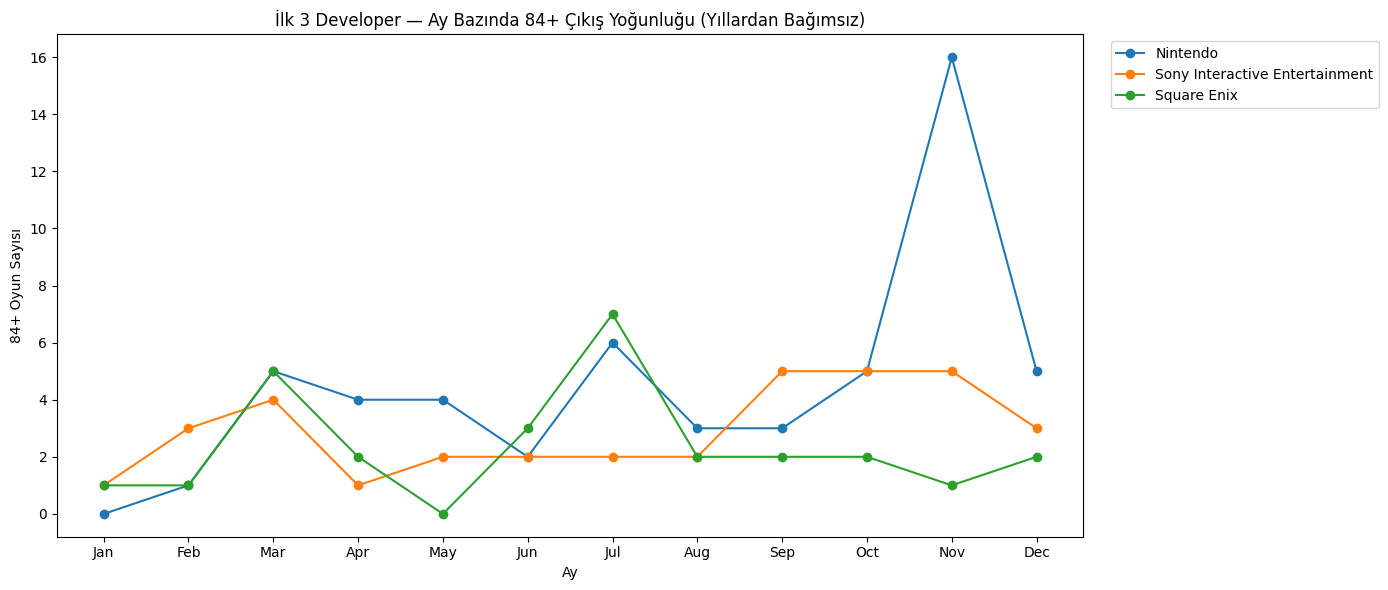

In [69]:
import calendar
import matplotlib.pyplot as plt

# Ay numarasını çıkar
m = (df_top3
     .assign(month=lambda d: d["year_month"].dt.month)
     .groupby(["developer","month"]).size()
     .reset_index(name="count"))

fig, ax = plt.subplots(figsize=(14,6))
for dev in top3:
    s = m[m["developer"] == dev].set_index("month")["count"].reindex(range(1,13), fill_value=0)
    ax.plot(range(1,13), s.values, marker="o", label=dev)

ax.set_title("İlk 3 Developer — Ay Bazında 84+ Çıkış Yoğunluğu (Yıllardan Bağımsız)")
ax.set_xlabel("Ay")
ax.set_ylabel("84+ Oyun Sayısı")
ax.set_xticks(range(1,13))
ax.set_xticklabels(list(calendar.month_abbr)[1:])  # Jan, Feb, ...

ax.legend(bbox_to_anchor=(1.02,1), loc="upper left")
plt.tight_layout()
plt.show()

## 3.6 Publisher Analizi — Partnerlik Fırsatları (Hacim vs. 84+ Başarı)

Indie bir geliştirici için doğru **publisher** ile ortaklık; görünürlük, platform ilişkileri ve pazarlama gücü açısından kritik olabilir.  
Bu bölümde publisher’ları iki metrikle yan yana inceliyoruz:

- **Hacim (Top-5000 içinde çıkardıkları oyun sayısı)** → ağ genişliği / dağıtım gücü
- **Başarı (Metacritic ≥ 84 alan oyun sayısı)** → üst düzey kaliteyi pazara çıkarma kapasitesi

Amaç:  
- “Çok oyun çıkarıp 84+’ı düşük olan” publisher’lar → **yüksek hacim, daha erişilebilir partner** (niş ama fırsat).  
- “Hem hacmi hem 84+’ı yüksek” publisher’lar → **güçlü ama rekabetçi partner**.  
- “Hacmi düşük ama 84+’ı yüksek” publisher’lar → **seçici, prestijli niş partner**.

> Not: Bu analiz Top-5000 (Metacritic’e göre sıralı) örneklemi temel alır; pazarın tamamını değil, üst kalite kesitini temsil eder.

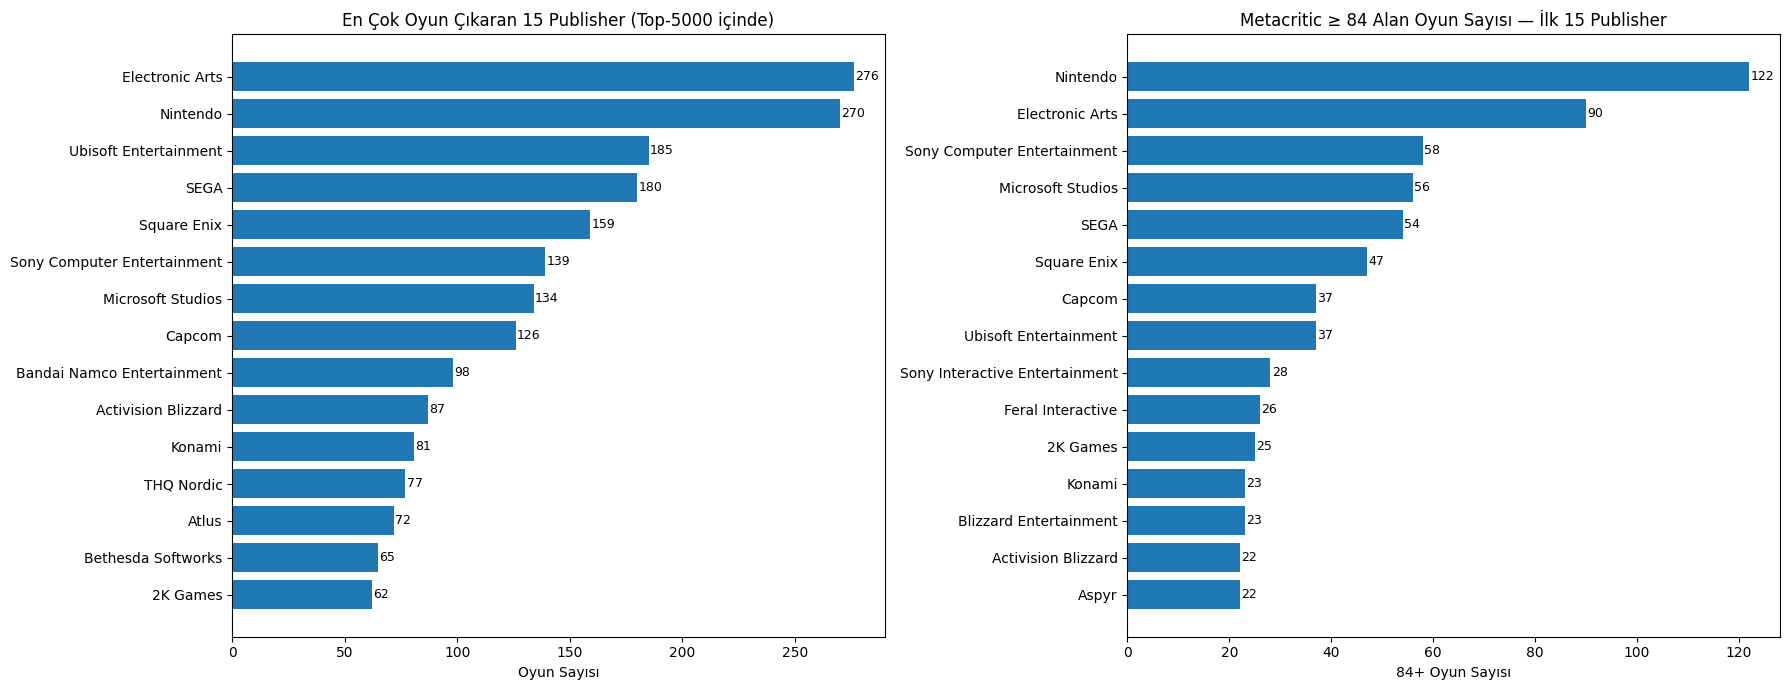

In [123]:
import pandas as pd
import matplotlib.pyplot as plt

THRESH = 84

# 1) Publisher'ları explode ederek tablo oluştur
rows = []
src = df_final.dropna(subset=["publishers", "metacritic_x"])
for _, row in src.iterrows():
    score = float(row["metacritic_x"])
    for p in row["publishers"].split(","):
        pub = p.strip()
        if pub:
            rows.append({"publisher": pub, "metacritic": score})

pubdf = pd.DataFrame(rows)

# 2) Hacim (n_total), 84+ sayısı (n_ge84), oran
agg_pub = (
    pubdf
    .assign(ge84=lambda d: (d["metacritic"] >= THRESH).astype(int))
    .groupby("publisher", as_index=False)
    .agg(n_total=("metacritic", "size"),
         n_ge84=("ge84", "sum"))
)
agg_pub["rate_ge84"] = (agg_pub["n_ge84"] / agg_pub["n_total"] * 100).round(1)

# 3) Görselleştirme — Top 15 (hacim ve 84+ sayısı)
top_total = agg_pub.sort_values("n_total", ascending=False).head(15)
top_ge84  = agg_pub.sort_values("n_ge84",  ascending=False).head(15)

fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Sol: En çok oyun çıkaran 15 publisher
bars1 = axes[0].barh(top_total["publisher"][::-1], top_total["n_total"][::-1])
axes[0].set_title("En Çok Oyun Çıkaran 15 Publisher (Top-5000 içinde)")
axes[0].set_xlabel("Oyun Sayısı")
for b in bars1:
    axes[0].text(b.get_width()+0.5, b.get_y()+b.get_height()/2,
                 int(b.get_width()), va="center", fontsize=9)

# Sağ: Metacritic ≥ 84 alan oyun sayısına göre 15 publisher
bars2 = axes[1].barh(top_ge84["publisher"][::-1], top_ge84["n_ge84"][::-1])
axes[1].set_title(f"Metacritic ≥ {THRESH} Alan Oyun Sayısı — İlk 15 Publisher")
axes[1].set_xlabel("84+ Oyun Sayısı")
for b in bars2:
    axes[1].text(b.get_width()+0.3, b.get_y()+b.get_height()/2,
                 int(b.get_width()), va="center", fontsize=9)

plt.tight_layout()
plt.show()


In [124]:
# Publisher bazında toplam oyun ve 84+ oyun sayısı + oran
pub_stats = (
    df_final.groupby("publishers")
    .agg(
        total_games=("rawg_id", "count"),
        high84_games=("rawg_id", lambda idx: (df_final.loc[idx.index, "metacritic_x"] >= 84).sum())
    )
    .reset_index()
)

# Oran (%)
pub_stats["high84_ratio"] = (pub_stats["high84_games"] / pub_stats["total_games"] * 100).round(1)

# En çok oyun çıkaran 15 publisher
top15_publishers = (
    pub_stats.sort_values("total_games", ascending=False)
    .head(15)
    .reset_index(drop=True)
)

# --- 40 barajına göre renklendirme ---
def highlight_groups_40(row):
    # 🟥 Yüksek hacim & düşük başarı
    if row["total_games"] > 100 and row["high84_ratio"] < 40:
        return ["background-color: #fdd"] * len(row)      # kırmızımsı
    # 🟩 Yüksek hacim & yüksek başarı
    elif row["total_games"] > 100 and row["high84_ratio"] >= 40:
        return ["background-color: #dfd"] * len(row)      # yeşilimsi
    # 🟦 Düşük hacim & yüksek başarı
    elif row["total_games"] <= 100 and row["high84_ratio"] >= 40:
        return ["background-color: #ddf"] * len(row)      # mavimsi
    # ⚪ Düşük hacim & düşük başarı
    else:
        return ["background-color: #eee"] * len(row)      # gri

styled = top15_publishers.style.apply(highlight_groups_40, axis=1)
styled


,publishers,total_games,high84_games,high84_ratio
0,Nintendo,233,109,46.800000
1,Electronic Arts,227,69,30.400000
2,Ubisoft Entertainment,152,31,20.400000
3,SEGA,117,29,24.800000
4,Capcom,104,30,28.800000
5,Sony Computer Entertainment,101,43,42.600000
6,Square Enix,101,29,28.700000
7,Konami,75,22,29.300000
8,Microsoft Studios,66,28,42.400000
9,Bethesda Softworks,52,16,30.800000


### Yorum — Publisher Analizi (40% Başarı Barajı ile)

Tablo, **publisher’ların çıkardıkları toplam oyun sayısı**, bunlardan **kaçının Metacritic ≥ 84 aldığı** ve oranlarını göstermektedir.  
Renkler üç farklı stratejik grubu ifade etmektedir:  

- 🟩 **Yüksek hacim & yüksek başarı**  
  - Örnek: **Nintendo (46.8%)**, **Sony Computer Entertainment (42.6%)**  
  - Çok sayıda oyun çıkarıp aynı zamanda yüksek başarı oranına ulaşabiliyorlar.  
  - Bu firmalarla partnerlik yapmak **prestijli ama zorlayıcı** olabilir; rekabet yüksek, kabul süreçleri seçici.  

- 🟥 **Yüksek hacim & düşük başarı**  
  - Örnek: **Electronic Arts (30.4%)**, **Ubisoft (20.4%)**, **SEGA (24.8%)**, **Capcom (28.8%)**, **Square Enix (28.7%)**  
  - Çok sayıda oyun çıkarıyorlar ancak 84+ oranı görece düşük.  
  - Indie geliştiriciler için **erişilebilir partnerlik fırsatları** sunabilir; oyun kalabalık havuzda kaybolma riski taşıyabilir ama yayıncı desteği daha ulaşılabilir.  

- 🟦 **Düşük hacim & yüksek başarı**  
  - Örnek: **Microsoft Studios (42.4%)**  
  - Daha az oyun çıkarıyorlar ancak başarı oranı yüksek.  
  - Partnerlik daha **niş ve seçici**, fakat **yüksek prestij** potansiyeli taşıyor.  

- ⚪ **Düşük hacim & düşük başarı**  
  - Örnek: **Bandai Namco Entertainment, Atlus, Devolver Digital, Warner Bros. Interactive**  
  - Oran da hacim de düşük.  
  - Partnerlik halinde büyük bir prestij sağlamaz ama belirli niş pazarlarda faydalı olabilir.  

---

### Çıkarım — Indie Geliştirici için Partnerlik
- Eğer **yüksek görünürlük ve prestij** hedefleniyorsa → 🟩 grubundaki publisher’lar tercih edilmeli.  
- Eğer **erişilebilirlik ve hızlı partnerlik** öncelikliyse → 🟥 grubundaki publisher’lar daha mantıklı olabilir.  
- Uzun vadede ise 🟦 grubundaki az ama başarılı publisher’lar, **kalite odaklı çıkış** için kritik fırsatlar sunabilir.  

👉 Bu analiz, indie geliştiricinin **hangi publisher tipi ile iş birliği yapmasının stratejik olarak uygun olacağını** netleştirmeyi amaçlıyor.  

## 3.7. Store Analizi — Oyunların Çıkış Yaptığı Platformlar

Publisher analizinden sonra şimdi odağımızı **oyunların hangi dijital mağazalarda (store) yayınlandığına** çeviriyoruz.  
Amacımız, indie bir geliştirici olarak oyunumuzu çıkarmak için **en doğru mağaza partnerini** seçmek.

### Analiz Adımları:
1. Her store’da toplam kaç oyun yayınlanmış?  
2. Bu oyunlardan kaç tanesi **Metacritic ≥ 84** barajını aşmış?  
3. Oranları karşılaştırarak hangi store’ların **prestijli ama zorlayıcı**, hangilerinin **erişilebilir ama rekabetçi** olduğunu belirlemek.  

Bu analiz, indie bir oyun için doğru mağaza seçimi stratejisine ışık tutacaktır.


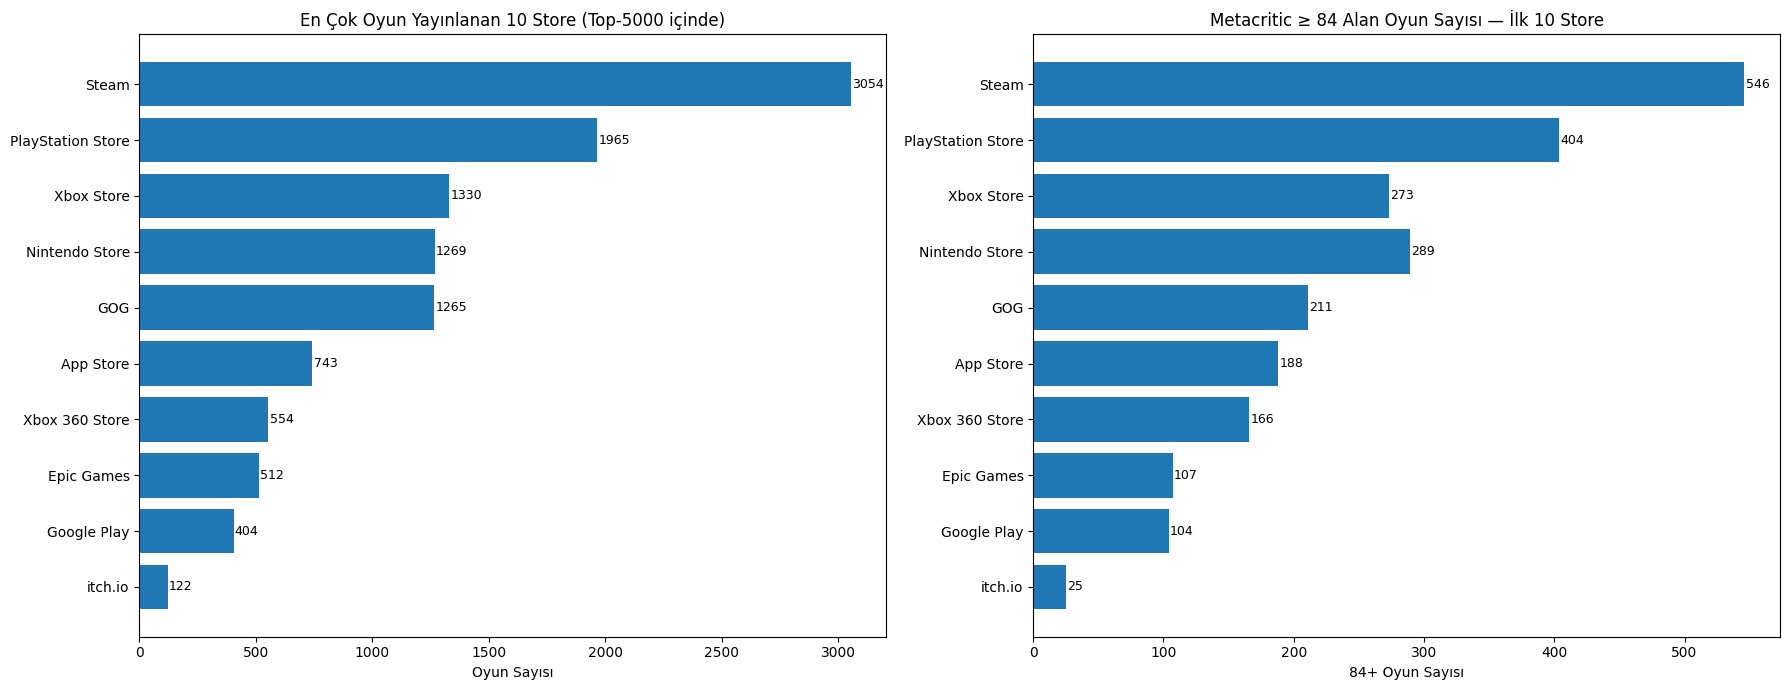

In [85]:
import matplotlib.pyplot as plt

# İlk 10 store (hacme göre)
top_stores = df_store_stats.head(10)

fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Sol grafik — toplam oyun sayısı
bars1 = axes[0].barh(top_stores["store"][::-1], top_stores["total_games"][::-1])
axes[0].set_title("En Çok Oyun Yayınlanan 10 Store (Top-5000 içinde)")
axes[0].set_xlabel("Oyun Sayısı")
for b in bars1:
    axes[0].text(b.get_width()+5, b.get_y()+b.get_height()/2,
                 int(b.get_width()), va="center", fontsize=9)

# Sağ grafik — 84+ oyun sayısı
bars2 = axes[1].barh(top_stores["store"][::-1], top_stores["high84_games"][::-1])
axes[1].set_title("Metacritic ≥ 84 Alan Oyun Sayısı — İlk 10 Store")
axes[1].set_xlabel("84+ Oyun Sayısı")
for b in bars2:
    axes[1].text(b.get_width()+1, b.get_y()+b.get_height()/2,
                 int(b.get_width()), va="center", fontsize=9)

plt.tight_layout()
plt.show()


In [125]:
from collections import Counter
import pandas as pd

# --- Mapping: farklı isimleri ortak gruba çevir ---
store_mapping = {
    "Xbox 360 Store": "Xbox Store",
    "Xbox One Store": "Xbox Store",
    "Xbox Series S/X Store": "Xbox Store",
    "PlayStation 3 Store": "PlayStation Store",
    "PlayStation 4 Store": "PlayStation Store",
    "PlayStation 5 Store": "PlayStation Store"
}

def normalize_store(name):
    return store_mapping.get(name, name)

# --- 1) Tüm oyunlarda store sayıları ---
all_stores = []
for s in df_final["stores"].dropna():
    for st in s.split(","):
        all_stores.append(normalize_store(st.strip()))

store_counts_all = Counter(all_stores)
df_stores_all = pd.DataFrame(store_counts_all.items(), columns=["store", "total_games"])

# --- 2) Sadece 84+ oyunlar ---
all_stores_84 = []
for s in df_final.loc[df_final["metacritic_x"] >= 84, "stores"].dropna():
    for st in s.split(","):
        all_stores_84.append(normalize_store(st.strip()))

store_counts_84 = Counter(all_stores_84)
df_stores_84 = pd.DataFrame(store_counts_84.items(), columns=["store", "high84_games"])

# --- 3) Birleştir ve oran hesapla ---
df_store_stats = (
    df_stores_all.merge(df_stores_84, on="store", how="left")
    .fillna(0)
    .assign(
        high84_games=lambda d: d["high84_games"].astype(int),
        high84_ratio=lambda d: (d["high84_games"] / d["total_games"] * 100).round(1)
    )
    .sort_values("total_games", ascending=False)
    .reset_index(drop=True)
)

# --- 4) İlk 10 store'u tablo olarak göster ---
top10_stores = df_store_stats.head(10).reset_index(drop=True)
top10_stores

,store,total_games,high84_games,high84_ratio
0,Steam,3054,546,17.9
1,PlayStation Store,1965,404,20.6
2,Xbox Store,1884,439,23.3
3,Nintendo Store,1269,289,22.8
4,GOG,1265,211,16.7
5,App Store,743,188,25.3
6,Epic Games,512,107,20.9
7,Google Play,404,104,25.7
8,itch.io,122,25,20.5


### Yorum — Store Seçimi ve Portlama Stratejisi  

**Tablodan öne çıkanlar:**  
- **Steam (3054 oyun, %17.9)**: En geniş oyun kütüphanesine sahip, indie oyunların ilk çıkış noktası. Ancak 84+ oranı görece düşük; kalabalık ortamda kaybolma riski yüksek.  
- **PlayStation Store (1965 oyun, %20.6)**: Daha seçici bir ortam, kalite oranı Steam’den daha iyi. Ancak portlama iş yükü yüksek, sertifikasyon süreçleri uzun.  
- **Xbox Store (1884 oyun, %23.3)**: 84+ oranı güçlü, özellikle Game Pass entegrasyonu görünürlük sağlar. Portlama iş yükü PlayStation’a benzer ama partnerlik fırsatları daha esnek.  
- **Nintendo Store (1269 oyun, %22.8)**: Özellikle indie platformer/metroidvania türleri için en uygun pazar. 84+ oranı yüksek, kitlesi sadık. Portlama orta zorlukta ama getirisi tür uyumuna göre çok yüksek.  
- **GOG (1265 oyun, %16.7)**: DRM’siz yapısı ve sadık PC oyuncusu kitlesi var. Ancak 84+ oranı düşük, satış hacmi sınırlı.  
- **App Store & Google Play (%25 civarı)**: Yüksek kalite oranı göze çarpıyor, fakat tamamen farklı iş modeli (F2P, mikro ödemeler). Oyunun türüne göre uygun olmayabilir.  
- **Epic Games (%20.9)**: Daha küçük kütüphane ama düşük komisyon (%12). Özellikle indie için cazip. Görünürlük fırsatı Epic anlaşmalarına bağlı.  
- **itch.io (%20.5)**: En düşük oyun sayısına sahip. Gelir küçük ama geliştirici özgürlüğü yüksek; topluluk bazlı test için uygun.  

---

### Çıkarım  
- **Başlangıç noktası (low risk, high reach):** Steam + Epic Games → düşük iş yükü, geniş erişim.  
- **İkinci dalga (prestij + tür uyumu):** Nintendo Store → metroidvania/platformer gibi türlerde stratejik avantaj.  
- **Stratejik partnerlik:** Xbox Store (Game Pass anlaşmaları) → yüksek görünürlük sağlar.  
- **Uzun vadeli hedef:** PlayStation Store → prestijli ama yüksek portlama maliyeti nedeniyle publisher desteği ile düşünülmeli.  

---

📌 **Özet:**  
İş yükü / getiriyi dengelemek için, **önce PC (Steam/Epic)** çıkışı → sonra **Nintendo veya Xbox** → en son **PlayStation (publisher partnerliğiyle)** doğru sıralama olacaktır.  


## Sonuç ve Öneriler (Özet)

**Veri kaynağı:** RAWG API – 5.000 oyun (en yüksek Metacritic sıralı).  
**Filtre / hedef:** 84+ puan barajı (üst segment kalite sinyali).

### 1) Zaman Dinamikleri
- Ortalama Metacritic zaman serisi pandemi sonrası (2020→) toparlanma gösterdi, ancak **84+ oyun sayısı 2016–2017 zirvesinden sonra azaldı.**
- Yorum: Pazarda **üst segment yoğunluk azalmış**, bu da kaliteli bir oyunun daha görünür olmasına fırsat tanıyor.

### 2) Türler (Kalite vs İlgi)
- **Kalite (84+ oranı / ortalama puan):** **Card, Platformer, Shooter** üst sıralarda.
- **İlgi (ratings_count & added medyanı):** **Shooter** ve **Massively Multiplayer** çok yüksek; **Card** da üstte.
- **Denge:** **Shooter** hem kalite hem ilgi tarafında güçlü; **Platformer** kaliteli ama ilgi daha düşük; **Card** iki tarafta da iyi.
- Öneri: Kaynak kısıtlıysa **Shooter (veya Card)** odağı; daha niş ama prestij hedefliyorsak **Platformer**.

### 3) Developer Rekabeti
- Top üretken stüdyolar ile 84+ çıkaranlar ayrışıyor.  
- **Nintendo** hem hacim hem 84+’ta zirvede → aynı tarihlere **çıkış çakışmasından kaçın**.  
- Gelecek çalışma (opsiyonel): Nintendo’nun pattern’leri (takvim/pazarlama/seri yönetimi) incelenip best practice çıkarımı.

### 4) Publisher Değerlendirmesi (40% barajıyla segmentasyon)
- **Yüksek hacim + yüksek başarı (yeşil):** Nintendo, Sony Computer Entertainment vb. → **güçlü ama rekabetçi partner**.
- **Yüksek hacim + daha düşük başarı (kırmızı):** Ubisoft Ent., SEGA, Capcom vb. → **erişilebilirlik daha yüksek**; doğru proje ile öne çıkma şansı.
- **Düşük hacim + yüksek başarı (mavi):** Microsoft Studios vb. → **seçici, prestijli niş partner**.

### 5) Store Stratejisi (portlama iş yükü dahil)
- **Başlangıç (low risk / high reach):** **Steam + Epic** (Epic’in %12 komisyon avantajı).  
- **İkinci dalga (prestij + tür uyumu):** **Nintendo eShop** (özellikle platformer/metroidvania) veya **Xbox (Game Pass)**.  
- **Uzun vadeli hedef:** **PlayStation Store** (yüksek sertifikasyon/iş yükü → publisher partnerliği ile).  
- Verisetinde 84+ oranları: Steam %17.9, PS %20.6, Xbox %23.3, Nintendo %22.8, Epic %20.9.

### 6) Takvim ve Çıkış
- Rekabetten kaçınmak için **Nintendo / Sony büyük lansman dönemlerinden kaçın** (önceki grafikteki yoğun aylara bak).  
- 84+ hedefi için **QA / playtest / demo (Steam Next Fest)** planı kritik.

---

## Yol Haritası (yapılabilir adımlar)
1. **Tür kararı:** Shooter ↔ Card (alternatif: prestij için Platformer).  
2. **Hedef metrik:** Metacritic **84+** → tasarım/QA bütçesi ve milestone’ları buna göre ayarla.  
3. **Çıkış sırası:** Steam → Epic → (uygunsa) Nintendo / Xbox → PlayStation (publisher ile).  
4. **Zamanlama:** Büyük Nintendo/Sony pencerelerinden kaçın; demo + wishlists kampanyası.  
5. **Publisher görüşmeleri:** Segment tablomuza göre 2–3 aday listele, vertical fit + referans case iste.  
6. **Ek analiz (opsiyonel):** Seçilen tür için **store bazlı performans** (ör. Shooter’ın Switch/PS/Xbox/PC dağılımı) ve **fiyatlandırma/indirim etkisi**.

### Sınırlamalar
- Örneklem top-5000 (Metacritic’e göre) → pazarın tamamını temsil etmeyebilir.  
- RAWG “genres” alanı heterojen (ör. “Indie” hariç tutularak düzeltildi).  
- 2024–2025 verileri **erken yıl etkisi** nedeniyle eksik olabilir.

**Kısa özet:**  
Kaliteyi (84+) hedefleyen ve popülerlik potansiyeli yüksek, **Shooter/Card** gibi bir türle; **Steam/Epic** çıkışı + **Nintendo/Xbox** ikinci dalga; **PlayStation** publisher’la. Büyük stüdyo lansmanlarından kaçınarak, demo/wishlist stratejisiyle görünürlüğü artır.


---

## 🎮 Meraklısına — Unutulmazlar

Her raporun sonunda, oyun dünyasının “zamansız klasikleri”ne de bir selam olsun.  
Aşağıda **Metacritic puanı 95+ olan oyunlar** listelenmiştir.  

Bu bölüm analizin bir parçası olmaktan ziyade, **oyun tutkusunu hatırlatmak için** eklenmiştir.  
Çünkü rakamlar ve istatistikler yolumuzu aydınlatsa da, **oyun geliştirme en nihayetinde bir tutku işidir.**

---


In [99]:
# 95+ oyunları filtrele
top95_games = df_final[df_final["metacritic_x"] >= 95]

# İlgili kolonları seç ve sıralamayı puana göre yap
top95_games = top95_games[["released", "name", "developers", "publishers", "metacritic_x"]] \
    .sort_values("metacritic_x", ascending=False)

# Yılı ayrı bir kolon olarak ekle
top95_games["year"] = top95_games["released"].dt.year

# Kolonları yeniden sırala
top95_games = top95_games[["year", "name", "developers", "publishers", "metacritic_x"]]

# Sonuçları göster
top95_games


,year,name,developers,publishers,metacritic_x
0,1998,The Legend of Zelda: Ocarina of Time,Nintendo,Nintendo,99
1,1998,Soulcalibur (1998),None,"Bandai Namco Entertainment, Namco",98
2,1998,Soulcalibur,"BANDAI NAMCO Entertainment America, NAMCO, Pro...","Bandai Namco Entertainment, Namco",98
3,2023,Baldur's Gate III,Larian Studios,Larian Studios,97
4,2002,Metroid Prime,Retro Studios,Nintendo,97
5,2000,Perfect Dark,"Rare, 4J Studios","Microsoft Studios, Rare",97
6,2017,Super Mario Odyssey,Nintendo,Nintendo,97
7,2010,Super Mario Galaxy 2,Nintendo,Nintendo,97
8,2007,Super Mario Galaxy,Nintendo,Nintendo,97
9,2017,The Legend of Zelda: Breath of the Wild,Nintendo,Nintendo,97
